<a href="https://colab.research.google.com/github/misanchz98/bitcoin-direction-prediction/blob/main/03_modeling/03_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Modelización con Redes Neuronales

In [9]:
!pip install boruta
!pip install keras-tcn --quiet

In [10]:
# =============================================================================
# LIBRERIAS
# =============================================================================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import Sequential, metrics
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import random

import warnings

# Establecer el nivel de advertencias a "ignore" para ignorar todas las advertencias
warnings.filterwarnings("ignore")

In [11]:
# resetting the seeds for reproducibility
def reset_random_seeds():
    n = 42
    os.environ['PYTHONHASHSEED'] = str(n)
    tf.random.set_seed(n)
    np.random.seed(n)
    random.seed(n)

reset_random_seeds()

## 🔹 1. Importación del conjunto de datos
El primer paso consiste en cargar el conjunto de datos en nuestro entorno de trabajo. Estos datos están almacenados en un archivo CSV llamado `btc_historical_data_eda.csv`, cuya creación y obtención se explican en el notebook `02_data_analysis.ipynb`. Para ello, se utiliza el siguiente fragmento de código:

In [12]:
# Importamos CSV
url = 'https://raw.githubusercontent.com/misanchz98/bitcoin-direction-prediction/main/02_data_analysis/data/btc_historical_data_eda.csv'
df_bitcoin = pd.read_csv(url, parse_dates=['Open time'])
df_bitcoin

,Open time,Close,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Range,Candle,Target,CMF_20,MFI_14,...,c2_ta_tendencia,c3_ta_tendencia,c1_ta_momentum,c2_ta_momentum,c3_ta_momentum,c4_ta_momentum,c5_ta_momentum,c1_ta_volatilidad,c2_ta_volatilidad,c3_ta_volatilidad
0,2017-10-05,4292.43,9158.0,351.042019,1.483037e+06,245.00,83.84,1,0.081329,56.225018,...,1.426309,-0.136861,1.317719,-0.126726,-1.676720,1.289633,0.019128,-4.644643,-0.938175,-0.259897
1,2017-10-06,4369.00,6546.0,226.148177,9.881066e+05,125.00,50.01,1,0.090972,62.048701,...,1.684975,-0.223654,1.843789,-0.313902,-0.766032,1.200655,0.108543,-4.656021,-1.404483,-0.298095
2,2017-10-07,4423.00,4804.0,145.313076,6.371469e+05,166.94,54.00,1,0.072898,60.780168,...,1.837639,-0.272101,1.714315,0.851111,-1.474281,-0.169404,-0.611932,-4.658149,-1.694457,-0.310605
3,2017-10-08,4640.00,7580.0,280.094854,1.268661e+06,233.00,215.00,1,0.064115,66.225272,...,2.655718,-0.595153,4.539268,-1.327677,-1.397994,0.344940,0.095779,-4.643444,-2.930102,-0.299058
4,2017-10-09,4786.95,10372.0,350.756559,1.654275e+06,339.98,146.95,0,0.105281,66.423592,...,3.068594,-0.711866,4.065484,0.284535,-0.496135,-0.373562,-0.383308,-4.619178,-3.116037,-0.259659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2025-08-16,117380.66,1179842.0,2995.228650,3.521588e+08,755.01,38.62,1,-0.078079,61.679789,...,-2.974279,-0.597347,-1.738575,-0.246759,0.045690,1.947962,-0.826190,11.130802,0.715864,-3.617415
2873,2025-08-17,117405.01,1177563.0,2804.731130,3.307994e+08,1402.79,24.35,0,-0.071478,61.441782,...,-3.056170,-0.520901,-2.679964,0.452454,-1.078307,1.833305,-0.382838,11.062656,0.708259,-3.717682
2874,2025-08-18,116227.05,3345487.0,7647.218200,8.850528e+08,2903.61,-1177.96,0,-0.058026,54.527915,...,-3.371373,-0.335897,-3.708156,1.216496,-0.767095,1.913662,1.633951,11.085307,1.427748,-3.651715
2875,2025-08-19,112872.94,3291170.0,8609.360780,9.840874e+08,3993.11,-3354.11,1,-0.133646,53.037041,...,-4.158761,0.112011,-5.328226,0.713262,0.105456,1.232647,-1.954862,11.229262,3.161925,-3.269720


## 🔹 2. División del conjunto de datos

In [13]:
# =======================================
# LIBRERÍAS
# =======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# =======================================
# MÉTRICA F1 PERSONALIZADA
# =======================================
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(tf.cast(y_pred, tf.float32))

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())


# =======================================
# BORUTA: SELECCIÓN DE FEATURES
# =======================================
def feature_selection_boruta(X, y):
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X.values, y.values)

    features = np.array(X.columns)
    confirmed = features[feat_selector.support_]
    tentative = features[feat_selector.support_weak_]
    rejected  = [f for f in features if f not in confirmed and f not in tentative]

    print("✅ Features confirmadas:", confirmed)
    print("⚠️ Features tentativas:", tentative)
    print("❌ Features rechazadas:", rejected)

    # Combinar confirmadas + tentativas
    selected = np.concatenate([confirmed, tentative])
    print("\n📌 Features finales (confirmadas + tentativas):", selected)
    return selected

# =======================================
# CREACIÓN DE SECUENCIAS
# =======================================
def create_windows_multivariate_np(data, target, window_size, horizon=1, shuffle=False):
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(target, (pd.DataFrame, pd.Series)):
        target = target.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(target[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        X, y = X[idx], y[idx]

    return X, y

def prepare_sequences(df, target_col="Target", window_size=30, horizon=1, selected_features=None):
    # Split temporal
    train_size = int(len(df) * 0.7)
    val_size   = int(len(df) * 0.15)

    df_train = df.iloc[:train_size]
    df_val   = df.iloc[train_size:train_size+val_size]
    df_test  = df.iloc[train_size+val_size:]

    # Separar features y target
    if selected_features is not None:
        features = selected_features
    else:
        features = df.columns.drop(target_col)

    X_train, y_train = df_train[features], df_train[target_col]
    X_val, y_val     = df_val[features], df_val[target_col]
    X_test, y_test   = df_test[features], df_test[target_col]

    # Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    # Crear secuencias
    X_train_seq, y_train_seq = create_windows_multivariate_np(X_train_scaled, y_train, window_size, horizon)
    X_val_seq, y_val_seq     = create_windows_multivariate_np(X_val_scaled, y_val, window_size, horizon)
    X_test_seq, y_test_seq   = create_windows_multivariate_np(X_test_scaled, y_test, window_size, horizon)

    print("✅ Datos listos:")
    print(f"   Train: {X_train_seq.shape}, {y_train_seq.shape}")
    print(f"   Val:   {X_val_seq.shape}, {y_val_seq.shape}")
    print(f"   Test:  {X_test_seq.shape}, {y_test_seq.shape}")

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, scaler

# =======================================
## DEFINICIÓN DE MODELOS
## =======================================

# 🔹 LSTM
def build_lstm(input_shape):
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=input_shape,
             kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        LSTM(128, return_sequences=True,
             kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        LSTM(64, kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=[f1_score_metric])
    return model


# 🔹 GRU
def build_gru(input_shape):
    model = Sequential([
        GRU(256, return_sequences=True, input_shape=input_shape,
            kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        GRU(128, return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        GRU(64, kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=[f1_score_metric])
    return model


# 🔹 CNN + LSTM
def build_lstm_cnn(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape,
               kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        LSTM(64, kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=[f1_score_metric])
    return model


# 🔹 CNN + GRU
def build_gru_cnn(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape,
               kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        MaxPooling1D(pool_size=2),
        GRU(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        GRU(64, kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dropout(0.3),
        Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4)),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=[f1_score_metric])
    return model

# =======================================
# PLOT DE ENTRENAMIENTO
# =======================================
def plot_training(history, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(history.history["loss"], label="Train Loss")
    axs[0].plot(history.history["val_loss"], label="Val Loss")
    axs[0].set_title(f"{model_name} - Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].legend()
    if "f1_score_metric" in history.history:
        axs[1].plot(history.history["f1_score_metric"], label="Train F1")
        axs[1].plot(history.history["val_f1_score_metric"], label="Val F1")
        axs[1].set_title(f"{model_name} - F1")
        axs[1].set_xlabel("Epochs")
        axs[1].legend()
    plt.show()

# =======================================
# ENTRENAMIENTO + EVALUACIÓN
# =======================================
from sklearn.utils import class_weight

def train_and_evaluate(model_fn, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    print(f"\n🚀 Entrenando modelo: {model_name}")
    model = model_fn(X_train.shape[1:])

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(
    #  monitor='val_loss',
    #  factor=0.5,
    #  patience=3, # 3 o 5 epocas para ser mas agresivo
    #  min_lr=1e-6,
    #  verbose=1
    #)


    # EarlyStopping en F1
    #es = tf.keras.callbacks.EarlyStopping(
    #    monitor="val_f1_score_metric",
    #    mode="max",
    #    patience=10,
    #    restore_best_weights=True
    #)

    # Pesos de clase (balanceo)
    #cw = class_weight.compute_class_weight(
    #    class_weight='balanced',
    #    classes=np.unique(y_train),
    #    y=y_train
    #)
    #cw = dict(enumerate(cw))

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        #class_weight=cw,
        verbose=1
    )

    # Predicciones
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # 📊 Métricas adicionales
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n📊 Resultados {model_name}:")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   F1-score : {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

    plot_training(history, model_name)
    return model, history


# =======================================
# PIPELINE PRINCIPAL
# =======================================
#def run_pipeline(df, target_col="Target", window_size=30, horizon=1):
#    # 1. Selección de features Boruta (confirmadas + tentativas)
#    selected_features = feature_selection_boruta(
#        df.drop(columns=[target_col]),
#        df[target_col]
#    )
#
#    # 2. Preparar secuencias
#    X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, scaler = prepare_sequences(
#        df,
#        target_col=target_col,
#        window_size=window_size,
#        horizon=horizon,
#        selected_features=selected_features
#    )
#
#    # 3. Entrenar y evaluar los 4 modelos
#    models = {
#        "LSTM": build_lstm,
#        "GRU": build_gru,
#        "LSTM+CNN": build_lstm_cnn,
#        "GRU+CNN": build_gru_cnn
#    }
#
#    trained_models = {}
#    for name, fn in models.items():
#        trained_models[name], _ = train_and_evaluate(
#            fn, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, name
#        )
#
#    return trained_models

#def run_pipeline_windows(df, target_col="Target", window_sizes=[7, 14, 20, 30, 60, 90], horizon=1):
#    # 1. Selección de features Boruta (solo una vez)
#    selected_features = feature_selection_boruta(
#        df.drop(columns=[target_col]),
#        df[target_col]
#    )
#
#    # 2. Separar features y target (sin crear secuencias aún)
#    features = selected_features
#    X_all, y_all = df[features], df[target_col]
#
#    # Escalado (una sola vez)
#    scaler = StandardScaler()
#    X_scaled = scaler.fit_transform(X_all)
#
#    # Diccionarios para resultados
#    trained_models_by_window = {}
#    metrics_list = []
#
#    for w in window_sizes:
#        print(f"\n==============================")
#        print(f"🔹 Probando ventana: {w} días")
#        print(f"==============================")
#
#        # Crear secuencias
#        X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, _ = prepare_sequences(
#            df,
#            target_col=target_col,
#            window_size=w,
#            horizon=horizon,
#            selected_features=selected_features
#        )
#
#        # Definir modelos
#        models = {
#            "LSTM": build_lstm,
#            "GRU": build_gru,
#            "LSTM+CNN": build_lstm_cnn,
#            "GRU+CNN": build_gru_cnn
#        }
#
#        trained_models = {}
#        for name, fn in models.items():
#            trained_models[name], _ = train_and_evaluate(
#                fn, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, name
#            )
#
#            # Calcular F1 en test
#            y_pred_prob = trained_models[name].predict(X_test_seq)
#            y_pred = (y_pred_prob > 0.5).astype("int32")
#            f1 = f1_score(y_test_seq, y_pred)
#            metrics_list.append({
#                "window_size": w,
#                "model": name,
#                "f1_score": f1
#            })
#
#        trained_models_by_window[w] = trained_models
#
#    # Crear DataFrame de métricas
#    metrics_df = pd.DataFrame(metrics_list)
#    pivot_df = metrics_df.pivot(index="window_size", columns="model", values="f1_score")
#
#    return trained_models_by_window, metrics_df, pivot_df
#

#def build_lstm_simple(input_shape):
#    model = Sequential([
#        LSTM(64, input_shape=input_shape, return_sequences=False),
#        Dropout(0.2),
#        Dense(32, activation="relu"),
#        Dropout(0.2),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(learning_rate=0.001),
#                  loss="binary_crossentropy",
#                  metrics=[f1_score_metric])
#    return model
#
#def build_gru_simple(input_shape):
#    model = Sequential([
#        GRU(64, input_shape=input_shape, return_sequences=False),
#        Dropout(0.2),
#        Dense(32, activation="relu"),
#        Dropout(0.2),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(learning_rate=0.001),
#                  loss="binary_crossentropy",
#                  metrics=[f1_score_metric])
#    return model
#
#def build_lstm_cnn_simple(input_shape):
#    model = Sequential([
#        Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
#        MaxPooling1D(pool_size=2),
#        LSTM(32, return_sequences=False),
#        Dropout(0.2),
#        Dense(16, activation="relu"),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(learning_rate=0.001),
#                  loss="binary_crossentropy",
#                  metrics=[f1_score_metric])
#    return model
#
#def build_gru_cnn_simple(input_shape):
#    model = Sequential([
#        Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
#        MaxPooling1D(pool_size=2),
#        GRU(32, return_sequences=False),
#        Dropout(0.2),
#        Dense(16, activation="relu"),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(learning_rate=0.001),
#                  loss="binary_crossentropy",
#                  metrics=[f1_score_metric])
#    return model
#
#
#from sklearn.model_selection import TimeSeriesSplit
#
#from sklearn.model_selection import TimeSeriesSplit
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#import tensorflow as tf
#import pandas as pd
#
#import pandas as pd
#import numpy as np
#import tensorflow as tf
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import TimeSeriesSplit
#




#def run_pipeline_walkforward(df, target_col="Target", window_sizes=[30], horizon=1, n_splits=5):
#    # 1. Selección de features con Boruta (una sola vez)
#    selected_features = feature_selection_boruta(
#        df.drop(columns=[target_col]),
#        df[target_col]
#    )
#
#    features = selected_features
#
#    # 2. Configuración walk-forward
#    tscv = TimeSeriesSplit(n_splits=n_splits)
#    metrics_list = []
#
#    for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
#        print(f"\n==============================")
#        print(f"📌 Walk-Forward Split {fold+1}/{n_splits}")
#        print(f"   Train: {train_idx[0]} → {train_idx[-1]}")
#        print(f"   Test : {test_idx[0]} → {test_idx[-1]}")
#        print("==============================")
#
#        df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
#
#        for w in window_sizes:
#            print(f"\n🔹 Ventana temporal: {w} días")
#
#            # Preparar secuencias (train+test juntos para mantener escalado consistente)
#            X_all_seq, y_all_seq, _, _, _, _, _ = prepare_sequences(
#                pd.concat([df_train, df_test]),
#                target_col=target_col,
#                window_size=w,
#                horizon=horizon,
#                selected_features=selected_features
#            )
#
#            # Ajustar split según tamaño de df_train
#            split_point = len(df_train) - w - horizon + 1
#
#            # 🚨 Evitar splits inválidos
#            if split_point <= 0:
#                print(f"❌ Saltando Split {fold+1}, ventana {w} (muy pocos datos para entrenar)")
#                continue
#
#            X_train_seq, y_train_seq = X_all_seq[:split_point], y_all_seq[:split_point]
#            X_test_seq, y_test_seq   = X_all_seq[split_point:], y_all_seq[split_point:]
#
#            if len(X_test_seq) == 0:
#                print(f"❌ Saltando Split {fold+1}, ventana {w} (sin datos de test)")
#                continue
#
#            # Definir modelos
#            models = {
#                "LSTM": build_lstm_simple,
#                "GRU": build_gru_simple,
#                "LSTM+CNN": build_lstm_cnn_simple,
#                "GRU+CNN": build_gru_cnn_simple
#            }
#
#            for name, fn in models.items():
#                print(f"\n🚀 Entrenando {name} (Split {fold+1}, ventana {w})")
#                model = fn(X_train_seq.shape[1:])
#
#                es = tf.keras.callbacks.EarlyStopping(
#                    monitor="val_loss",
#                    patience=5,
#                    restore_best_weights=True
#                )
#
#                history = model.fit(
#                    X_train_seq, y_train_seq,
#                    validation_split=0.1,  # usar parte del train como validación
#                    epochs=50,
#                    batch_size=32,
#                    callbacks=[es],
#                    verbose=0
#                )
#
#                # 🔹 Graficar entrenamiento
#                plot_training(history, f"{name} - Split {fold+1}, ventana {w}")
#
#                # Predicciones en test
#                y_pred_prob = model.predict(X_test_seq)
#                y_pred = (y_pred_prob > 0.5).astype("int32")
#
#                # Métricas
#                acc = accuracy_score(y_test_seq, y_pred)
#                prec = precision_score(y_test_seq, y_pred, zero_division=0)
#                rec = recall_score(y_test_seq, y_pred, zero_division=0)
#                f1 = f1_score(y_test_seq, y_pred, zero_division=0)
#
#                print(f"✅ {name} - Split {fold+1}, ventana {w}: F1={f1:.4f}")
#
#                metrics_list.append({
#                    "split": fold+1,
#                    "window_size": w,
#                    "model": name,
#                    "accuracy": acc,
#                    "precision": prec,
#                    "recall": rec,
#                    "f1_score": f1
#                })
#
#    # Convertir métricas a DataFrame
#    metrics_df = pd.DataFrame(metrics_list)
#    return metrics_df
#

# PROBLEMA: Las secuencias se crean independientemente
# Esto puede causar "gaps" en los datos

# SOLUCIÓN MEJORADA:
#def run_pipeline_walkforward(df, target_col="Target", window_sizes=[7,14], horizon=1, n_splits=5):
#    # Selección de features
#    selected_features = feature_selection_boruta(
#        df.drop(columns=[target_col]),
#        df[target_col]
#    )
#
#    # Crear TODAS las secuencias primero
#    scaler = StandardScaler()
#    X_scaled = scaler.fit_transform(df[selected_features])
#
#    metrics_list = []
#
#    for w in window_sizes:
#        print(f"\n🔹 Ventana temporal: {w} días")
#
#        # Crear todas las secuencias
#        X_all_seq, y_all_seq = create_windows_multivariate_np(
#            X_scaled, df[target_col], window_size=w, horizon=horizon
#        )
#
#        # Ahora aplicar walk-forward sobre las secuencias
#        tscv = TimeSeriesSplit(n_splits=n_splits)
#
#        for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all_seq)):
#            X_train_seq = X_all_seq[train_idx]
#            y_train_seq = y_all_seq[train_idx]
#            X_test_seq = X_all_seq[test_idx]
#            y_test_seq = y_all_seq[test_idx]
#
#            # Validación temporal dentro del train
#            train_size = int(len(X_train_seq) * 0.9)
#            X_train_fold = X_train_seq[:train_size]
#            y_train_fold = y_train_seq[:train_size]
#            X_val_fold = X_train_seq[train_size:]
#            y_val_fold = y_train_seq[train_size:]
#
#            # Entrenar modelos...
#            models = {
#                "LSTM": build_lstm_simple,
#                "GRU": build_gru_simple,
#                "LSTM+CNN": build_lstm_cnn_simple,
#                "GRU+CNN": build_gru_cnn_simple
#            }
#
#            for name, fn in models.items():
#                model = fn(X_train_seq.shape[1:])
#                print(f"\n🚀 Entrenando {name} (Split {fold+1}, ventana {w})")
#                es = tf.keras.callbacks.EarlyStopping(
#                    monitor="val_loss", patience=5, restore_best_weights=True
#                )
#
#                history = model.fit(
#                    X_train_fold, y_train_fold,
#                    validation_data=(X_val_fold, y_val_fold),  # ✅ Validación temporal
#                    epochs=50,
#                    batch_size=32,
#                    callbacks=[es],
#                    verbose=0
#                )
#
#                # Graficar entrenamiento
#                plot_training(history, f"{name} - Split {fold+1}, ventana {w}")
#
#                # Predicciones en test
#                y_pred_prob = model.predict(X_test_seq, batch_size=32)
#                y_pred = (y_pred_prob > 0.5).astype("int32")
#
#                # Métricas
#                acc = accuracy_score(y_test_seq, y_pred)
#                prec = precision_score(y_test_seq, y_pred, zero_division=0)
#                rec = recall_score(y_test_seq, y_pred, zero_division=0)
#                f1 = f1_score(y_test_seq, y_pred, zero_division=0)
#
#                print(f"✅ {name} - Split {fold+1}, ventana {w}: F1={f1:.4f}")
#
#                metrics_list.append({
#                    "split": fold+1,
#                    "window_size": w,
#                    "model": name,
#                    "accuracy": acc,
##                    "precision": prec,
#                    "recall": rec,
#                    "f1_score": f1
#                })
#
#    return pd.DataFrame(metrics_list)

#def run_pipeline_walkforward(df, target_col="Target", window_sizes=[7,14], horizon=1, n_splits=5):
#    # 1️⃣ Selección de features con Boruta (una sola vez)
#    selected_features = feature_selection_boruta(
#        df.drop(columns=[target_col]),
#        df[target_col]
#    )
#    features = selected_features
#
#    # 2️⃣ Configuración walk-forward
#    tscv = TimeSeriesSplit(n_splits=n_splits)
#    metrics_list = []
#
#    for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
#        print(f"\n==============================")
#        print(f"📌 Walk-Forward Split {fold+1}/{n_splits}")
#        print(f"   Train: {train_idx[0]} → {train_idx[-1]}")
#        print(f"   Test : {test_idx[0]} → {test_idx[-1]}")
#        print("==============================")
#
#        df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
#
#        for w in window_sizes:
#            print(f"\n🔹 Ventana temporal: {w} días")
#
#            # Escalar features
#            scaler = StandardScaler()
#            X_train_scaled = scaler.fit_transform(df_train[features])
#            X_test_scaled  = scaler.transform(df_test[features])
#
#            # Crear secuencias separadas para train y test
#            X_train_seq, y_train_seq = create_windows_multivariate_np(
#                X_train_scaled, df_train[target_col], window_size=w, horizon=horizon
#            )
#            X_test_seq, y_test_seq = create_windows_multivariate_np(
#                X_test_scaled, df_test[target_col], window_size=w, horizon=horizon
#            )
#
#            # Saltar split si no hay secuencias suficientes
#            if len(X_train_seq) == 0 or len(X_test_seq) == 0:
#                print(f"❌ Split {fold+1}, ventana {w} no tiene datos suficientes, se salta")
#                continue
#
#            # Modelos simplificados
#            models = {
#                "LSTM": build_lstm,
#                "GRU": build_gru,
#                "LSTM+CNN": build_lstm_cnn,
#                "GRU+CNN": build_gru_cnn
#            }
#
#            for name, fn in models.items():
#                print(f"\n🚀 Entrenando {name} (Split {fold+1}, ventana {w})")
#                model = fn(X_train_seq.shape[1:])
#
#                es = tf.keras.callbacks.EarlyStopping(
#                    monitor="val_loss",
#                    patience=5,
#                    restore_best_weights=True
#                )
#
#                history = model.fit(
#                    X_train_seq, y_train_seq,
#                    validation_split=0.1,
#                    epochs=50,
#                    batch_size=32,
#                    callbacks=[es],
#                    verbose=0
#                )
#
#                # Graficar entrenamiento
#                plot_training(history, f"{name} - Split {fold+1}, ventana {w}")
#
#                # Predicciones en test
#                y_pred_prob = model.predict(X_test_seq, batch_size=32)
#                y_pred = (y_pred_prob > 0.5).astype("int32")
#
#                # Métricas
#                acc = accuracy_score(y_test_seq, y_pred)
#                prec = precision_score(y_test_seq, y_pred, zero_division=0)
#                rec = recall_score(y_test_seq, y_pred, zero_division=0)
#                f1 = f1_score(y_test_seq, y_pred, zero_division=0)
#
#                print(f"✅ {name} - Split {fold+1}, ventana {w}: F1={f1:.4f}")
#
#                metrics_list.append({
#                    "split": fold+1,
#                    "window_size": w,
#                    "model": name,
#                    "accuracy": acc,
#                    "precision": prec,
#                    "recall": rec,
#                    "f1_score": f1
#                })
#
#    # Convertir métricas a DataFrame
#    metrics_df = pd.DataFrame(metrics_list)
#    return metrics_df


#import seaborn as sns
#import matplotlib.pyplot as plt
#
#def plot_walkforward_heatmap(metrics_df, metric="f1_score"):
#    """
#    Heatmap de desempeño de modelos en splits walk-forward.
#
#    Args:
#        metrics_df: DataFrame devuelto por run_pipeline_walkforward
#        metric: métrica a graficar (ej. "f1_score", "accuracy", etc.)
#    """
#    pivot_df = metrics_df.pivot_table(
#        index="model", columns="split", values=metric, aggfunc="mean"
#    )
#
#    plt.figure(figsize=(10, 6))
#    sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={"label": metric})
#    plt.title(f"Walk-Forward {metric.capitalize()} por Modelo y Split", fontsize=14)
#    plt.xlabel("Split temporal (futuro)")
#    plt.ylabel("Modelo")
#    plt.show()
#

In [14]:
#df_bitcoin = df_bitcoin.drop(["Open time"], axis=1)
#trained_models_by_window, metrics_df, pivot_df = run_pipeline_windows(df_bitcoin)
#
## Mostrar resultados
#print(pivot_df)
#
## Gráfico comparativo
#plt.figure(figsize=(10,6))
#for model_name in pivot_df.columns:
#    plt.plot(pivot_df.index, pivot_df[model_name], marker='o', label=model_name)
#
#plt.title("Comparación de F1-score por ventana y modelo")
#plt.xlabel("Tamaño de ventana (días)")
#plt.ylabel("F1-score en Test")
#plt.xticks(pivot_df.index)
#plt.grid(True)
#plt.legend()
#plt.show()

#df_bitcoin = df_bitcoin.drop(["Open time"], axis=1)
#
#metrics_df = run_pipeline_walkforward(
#    df_bitcoin,
#    target_col="Target",
#    window_sizes=[7, 14, 30, 60],  # puedes probar varias
#    horizon=1,
#    n_splits=3
#)
#
#print(metrics_df)
#
## Ver promedio por modelo
#print(metrics_df.groupby("model")["f1_score"].mean())
#
## Ejemplo de uso:
#plot_walkforward_heatmap(metrics_df, metric="f1_score")

In [15]:
# =======================================
# IMPORTS
# =======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)

from sklearn.model_selection import BaseCrossValidator
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D,
                                     Flatten, Input, LayerNormalization)
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# =======================================
# SPLIT PURGADO WALK-FORWARD
# =======================================
class PurgedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits=4, embargo=0, test_size=0.2):
        self.n_splits = n_splits
        self.embargo = embargo
        self.test_size = test_size

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        test_size = int(n_samples * self.test_size)
        n_trainval = n_samples - test_size
        fold_sizes = np.linspace(0.5, 1.0, self.n_splits+1)

        for i in range(self.n_splits):
            end = int(fold_sizes[i+1] * n_trainval)
            val_size = int(0.15 * end)
            val_start = end - val_size
            val_end = end
            train_end = max(0, val_start - self.embargo)
            train_idx = np.arange(0, train_end)
            val_idx = np.arange(val_start, val_end)

            yield train_idx, val_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

# =======================================
# MÉTRICA F1 PERSONALIZADA
# =======================================
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(tf.cast(y_pred, tf.float32))
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

# =======================================
# CREACIÓN DE SECUENCIAS
# =======================================
def create_windows_multivariate_np(data, target, window_size, horizon=1, shuffle=False):
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(target, (pd.DataFrame, pd.Series)):
        target = target.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(target[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        X, y = X[idx], y[idx]

    return X, y

# =======================================
# MODELOS BASE
# =======================================
def build_lstm_simple(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
    return model

def build_gru_simple(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
    return model

def build_lstm_cnn_simple(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
    return model

def build_gru_cnn_simple(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
    return model

# =======================================
# NUEVOS MODELOS (TRANSFORMER + TCN)
# =======================================
def build_transformer_encoder(input_shape, num_heads=4, ff_dim=64):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
    return model

def build_tcn_simple(input_shape, nb_filters=32, kernel_size=3, nb_stacks=1, dilations=[1,2,4,8]):
    from tcn import TCN
    model = Sequential([
        TCN(nb_filters=nb_filters, kernel_size=kernel_size, dilations=dilations,
            nb_stacks=nb_stacks, dropout_rate=0.2, return_sequences=False,
            input_shape=input_shape),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
    return model

# =======================================
# EVALUACIÓN
# =======================================
def evaluate_metrics(y_true, y_pred, returns=None):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "mcc": matthews_corrcoef(y_true, y_pred)
    }
    if returns is not None:
        strat_returns = np.where(y_pred==1, returns, -returns)
        metrics["cum_return"] = strat_returns.cumsum()[-1]
        metrics["sharpe"] = strat_returns.mean() / (strat_returns.std() + 1e-8)
    return metrics

# =======================================
# FEATURE IMPORTANCE
# =======================================
def permutation_importance_seq(model, X_val, y_val, features, n_repeats=5):
    baseline_acc = accuracy_score(y_val, (model.predict(X_val) > 0.5).astype(int))
    importances = {}
    for j, feat in enumerate(features):
        scores = []
        X_val_permuted = X_val.copy()
        for _ in range(n_repeats):
            np.random.shuffle(X_val_permuted[:, :, j])
            acc = accuracy_score(y_val, (model.predict(X_val_permuted) > 0.5).astype(int))
            scores.append(baseline_acc - acc)
        importances[feat] = np.mean(scores)
    return pd.Series(importances).sort_values(ascending=False)

# =======================================
# RESUMEN DE MÉTRICAS
# =======================================
def summarize_results(metrics_df):
    summary = metrics_df.groupby("model").agg(["mean", "std"])
    # ordenar por F1
    summary = summary.sort_values(("f1", "mean"), ascending=False)
    return summary.round(4)

def aggregate_feature_importances(feature_importances_all, top_n=10):
    agg_results = {}
    for model_name in set([d["model"] for d in feature_importances_all]):
        imps = [d["importances"] for d in feature_importances_all if d["model"] == model_name]
        if imps:
            imp_mean = pd.concat(imps, axis=1).mean(axis=1).sort_values(ascending=False)
            agg_results[model_name] = imp_mean.head(top_n)
            plt.figure(figsize=(8,5))
            imp_mean.head(top_n).plot(kind="barh")
            plt.gca().invert_yaxis()
            plt.title(f"Top-{top_n} Features ({model_name})")
            plt.show()
    return agg_results

def plot_feature_importance_heatmap(feature_importances_all, top_n=10):
    agg_results = aggregate_feature_importances(feature_importances_all, top_n)
    df_heatmap = pd.DataFrame(agg_results).fillna(0)
    plt.figure(figsize=(10,6))
    sns.heatmap(df_heatmap, annot=True, fmt=".3f", cmap="YlOrBr")
    plt.title(f"Heatmap Features vs Modelos (Top-{top_n})")
    plt.show()

# =======================================
# PIPELINE WALK-FORWARD
# =======================================
def run_pipeline_walkforward(df, target_col="Target", return_col="Return",
                             window_size=30, horizon=1, n_splits=6, scaler_type="robust"):
    embargo = window_size + horizon - 1
    test_size = int(len(df) * 0.2)

    df_trainval = df.iloc[:-test_size]
    features = [c for c in df.columns if c not in [target_col, return_col]]
    print(f"\n📌 Usando todas las features: {features}")

    X_all = df_trainval[features].values
    y_all = df_trainval[target_col].values
    returns_all = df_trainval[return_col].values
    X_all_seq, y_all_seq = create_windows_multivariate_np(X_all, y_all, window_size, horizon)
    ret_seq = returns_all[window_size+horizon-1:]

    splitter = PurgedTimeSeriesSplit(n_splits=n_splits, embargo=embargo, test_size=0.2)
    metrics_list, feature_importances_all = [], []

    models = {
        "LSTM": build_lstm_simple,
        "GRU": build_gru_simple,
        "LSTM+CNN": build_lstm_cnn_simple,
        "GRU+CNN": build_gru_cnn_simple,
        "Transformer": build_transformer_encoder,
        "TCN": build_tcn_simple
    }

    for fold, (train_idx, val_idx) in enumerate(splitter.split(X_all_seq)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")
        X_train_raw, y_train = X_all_seq[train_idx], y_all_seq[train_idx]
        X_val_raw, y_val = X_all_seq[val_idx], y_all_seq[val_idx]
        r_val = ret_seq[val_idx]

        scaler = RobustScaler() if scaler_type=="robust" else StandardScaler()
        n_samples, seq_len, n_features = X_train_raw.shape
        X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, n_features)).reshape(n_samples, seq_len, n_features)
        X_val_scaled = scaler.transform(X_val_raw.reshape(-1, n_features)).reshape(X_val_raw.shape[0], seq_len, n_features)

        for name, fn in models.items():
            print(f"\n--- Modelo: {name} ---")
            model = fn(X_train_scaled.shape[1:])
            es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
            rlrop = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5)
            ckpt = ModelCheckpoint(f"best_{name}_fold{fold+1}.keras", save_best_only=True)

            model.fit(X_train_scaled, y_train,
                      validation_data=(X_val_scaled, y_val),
                      epochs=50, batch_size=32,
                      callbacks=[es, rlrop, ckpt], verbose=0)

            y_pred_val = (model.predict(X_val_scaled) > 0.5).astype("int32")
            metrics_val = evaluate_metrics(y_val, y_pred_val, returns=r_val)
            metrics_val.update({"fold": fold+1, "model": name})
            metrics_list.append(metrics_val)

            imp = permutation_importance_seq(model, X_val_scaled.copy(), y_val, features)
            feature_importances_all.append({"fold": fold+1, "model": name, "importances": imp})

    return pd.DataFrame(metrics_list), feature_importances_all



📌 Usando todas las features: ['Close', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Range', 'Candle', 'CMF_20', 'MFI_14', 'ADL', 'OBV_diff', 'OBV_roc_5', 'OBV_ma20', 'OBV_ma_cross', 'CMF_diff', 'CMF_zscore', 'MFI_diff', 'MFI_zscore', 'ADL_diff', 'ADL_roc_5', 'Vol_SMA20', 'Vol_ratio_50', 'diff_Vol_SMA', 'diff_Vol_ratio', 'mempool_size', 'transaction_rate', 'average_block_size', 'exchange_volume_usd', 'average_confirmation_time', 'hash_rate', 'miners_revenue', 'total_transaction_fees', 'c1_ta_tendencia', 'c2_ta_tendencia', 'c3_ta_tendencia', 'c1_ta_momentum', 'c2_ta_momentum', 'c3_ta_momentum', 'c4_ta_momentum', 'c5_ta_momentum', 'c1_ta_volatilidad', 'c2_ta_volatilidad', 'c3_ta_volatilidad']

=== Fold 1/3 ===

--- Modelo: LSTM ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

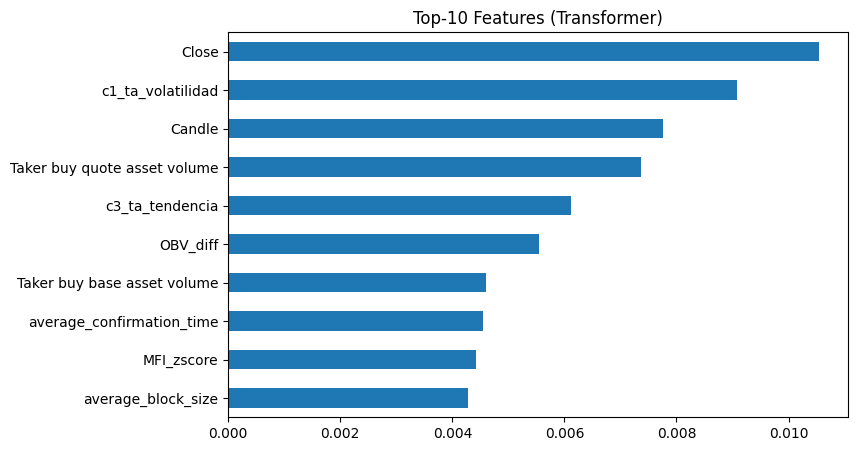

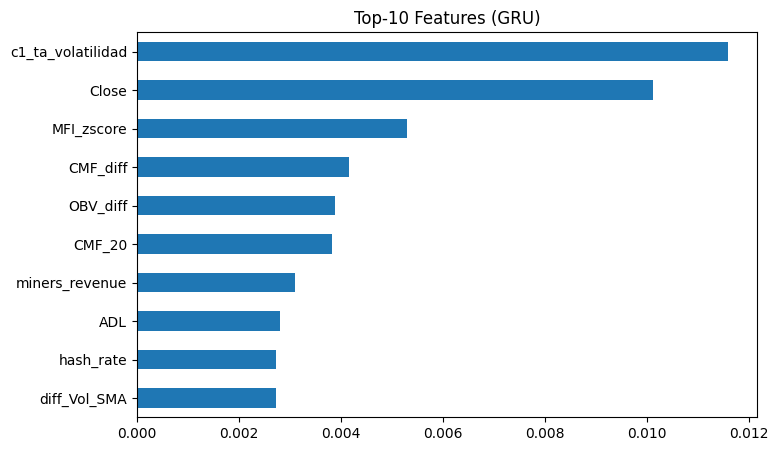

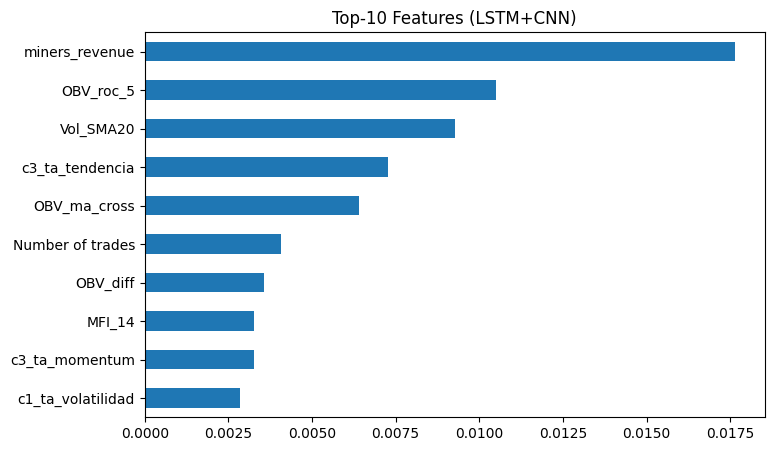

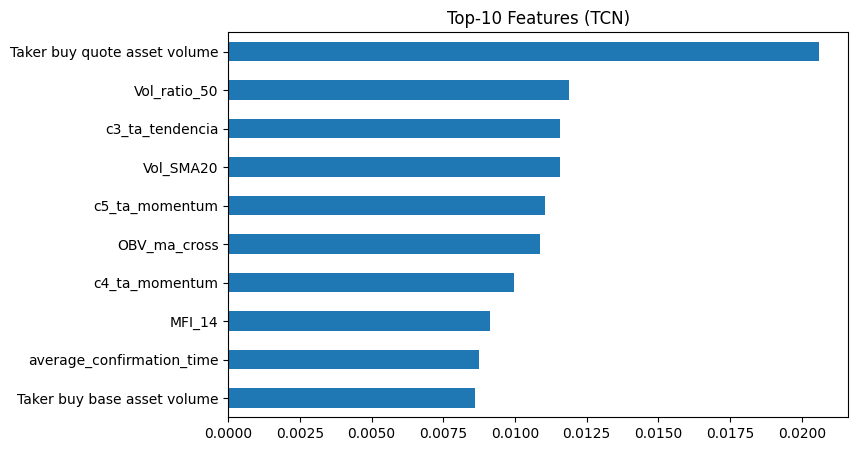

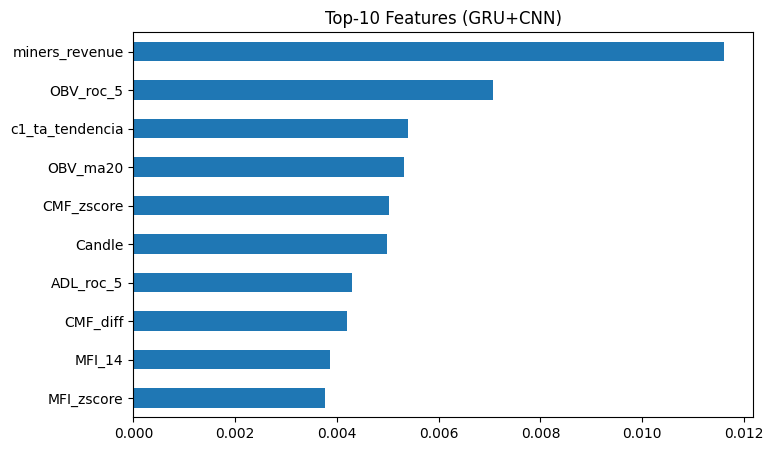

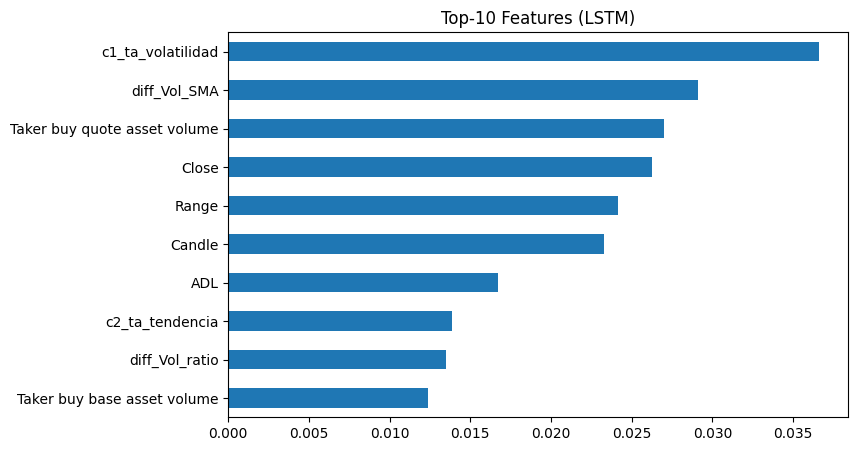

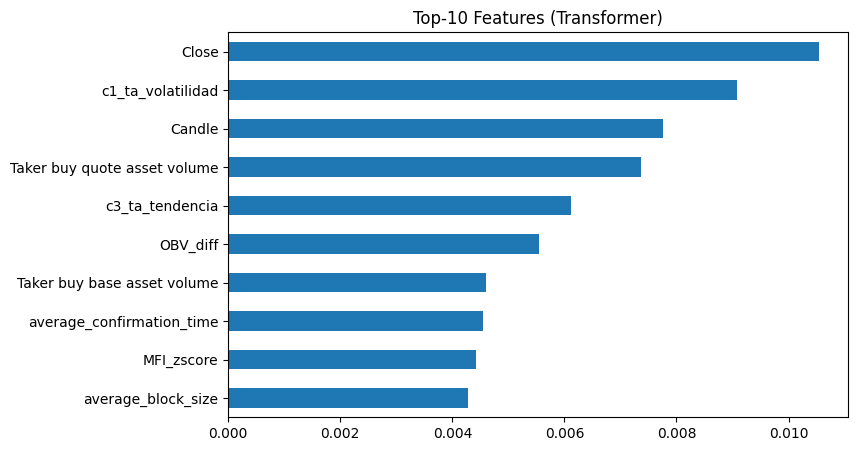

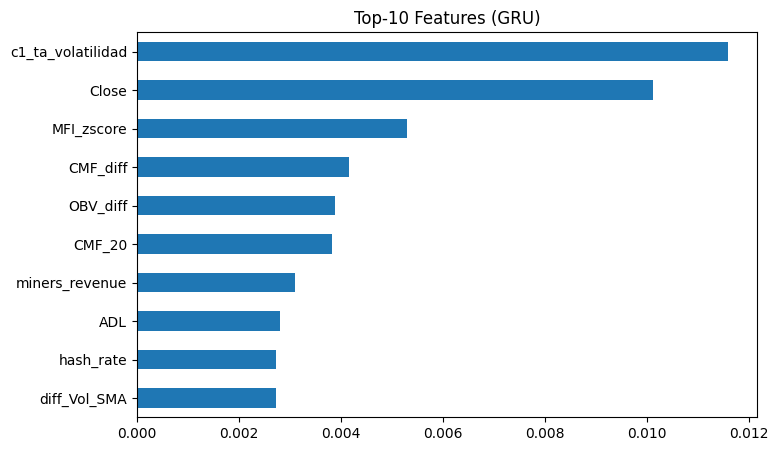

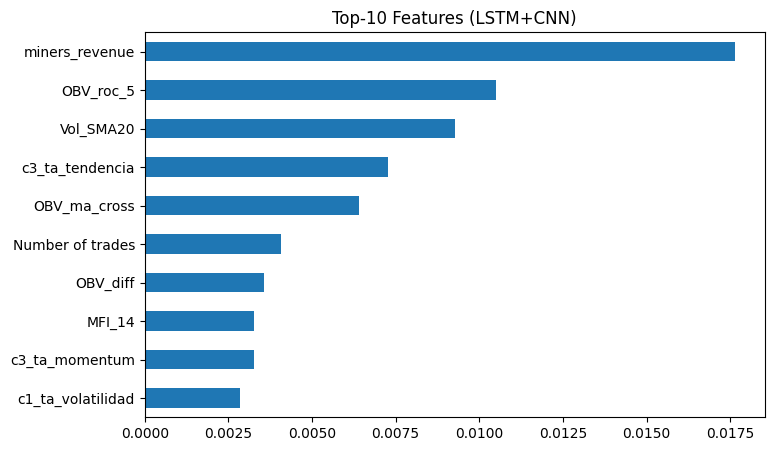

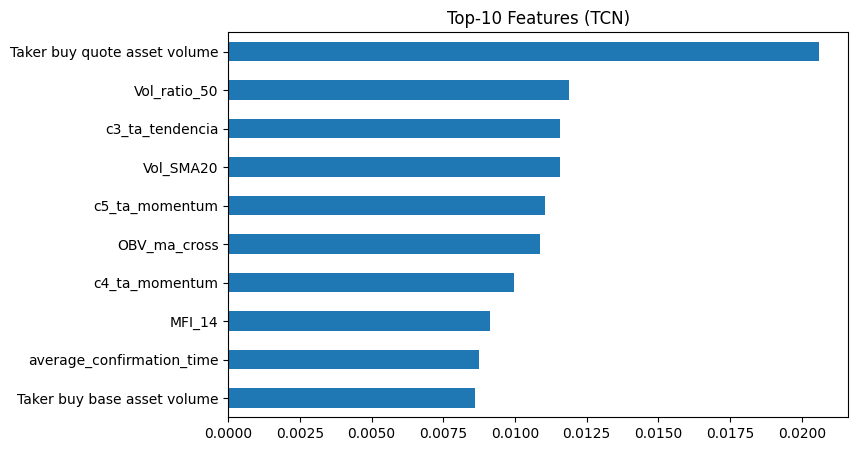

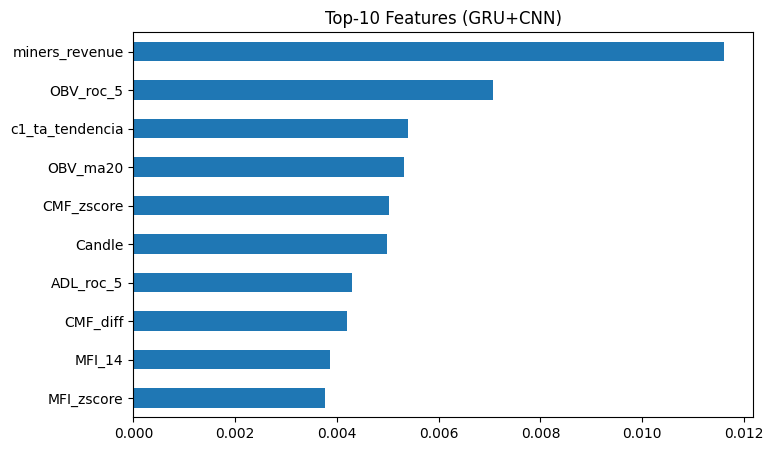

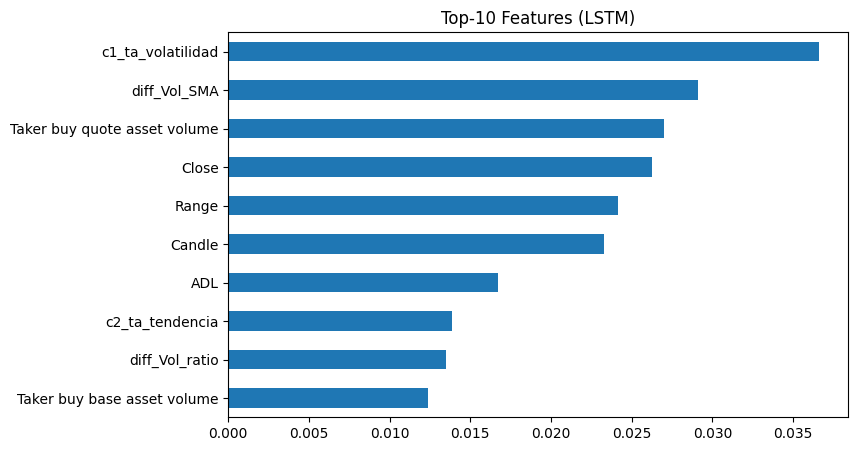

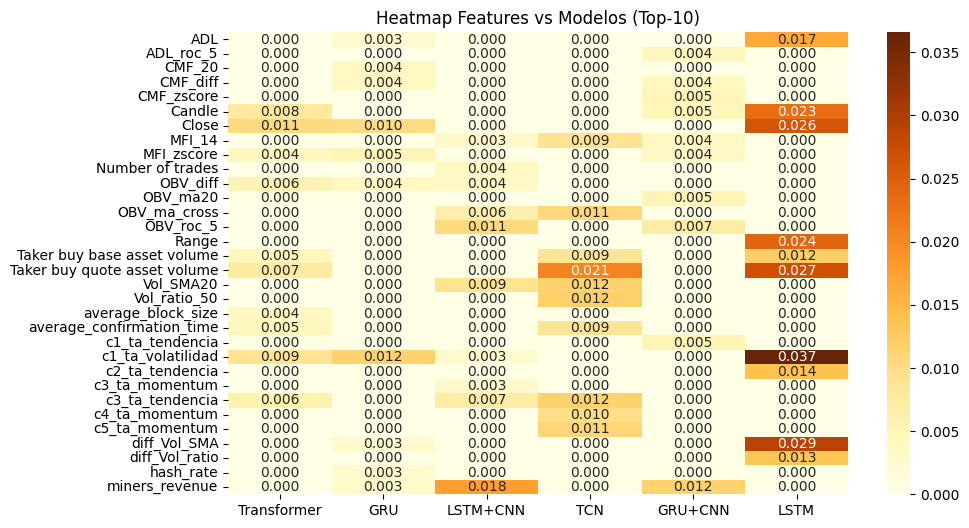

In [16]:
# === Prepara los datos ===
df_bitcoin = df_bitcoin.drop(["Open time"], axis=1)
df_bitcoin["Return"] = np.log(df_bitcoin["Close"] / df_bitcoin["Close"].shift(1)).fillna(0)

# === Ejecutar pipeline ===
results, features_importance_all = run_pipeline_walkforward(
    df_bitcoin, target_col="Target", return_col="Return",
    window_size=14, horizon=1, n_splits=3
)

# === Tabla bonita de métricas ===
print("\n📊 Resumen final:")
summary = summarize_results(results)
print(summary)

# === Importancia de features ===
agg_importances = aggregate_feature_importances(features_importance_all, top_n=10)

# === Heatmap comparativo ===
plot_feature_importance_heatmap(features_importance_all, top_n=10)



In [17]:
#trained_models_by_window, metrics_df, pivot_df = run_pipeline_windows(df_bitcoin)
#
## Mostrar resultados
#print(pivot_df)
#
## Gráfico comparativo
#plt.figure(figsize=(10,6))
#for model_name in pivot_df.columns:
#    plt.plot(pivot_df.index, pivot_df[model_name], marker='o', label=model_name)
#
#plt.title("Comparación de F1-score por ventana y modelo")
#plt.xlabel("Tamaño de ventana (días)")
#plt.ylabel("F1-score en Test")
#plt.xticks(pivot_df.index)
#plt.grid(True)
#plt.legend()
#plt.show()

In [18]:
# df_bitcoin debe contener:
# - Features (OHLC, volumen, indicadores…)
# - Columna "Target" con 0/1 (sube o baja)
#df_bitcoin = df_bitcoin.drop(columns=["Open time"], errors="ignore")
#trained_models = run_pipeline(df_bitcoin, target_col="Target", window_size=20, horizon=1)

In [19]:
#X = df_bitcoin.drop(['Open time', 'Target'], axis=1)
#y = df_bitcoin['Target']
#
## separate training data from testing data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
#
## scale the input data
#scaler = StandardScaler()
#
## Reshape X_train and X_test if they are 1D
#if X_train.ndim == 1:
#    X_train = X_train.to_numpy().reshape(-1, 1)
#if X_test.ndim == 1:
#    X_test = X_test.to_numpy().reshape(-1, 1)
#
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#
## reshape the input data for CNN-LSTM (samples, timesteps, features)
#def create_sequences(data, timesteps):
#    X = []
#    for i in range(len(data) - timesteps + 1):
#        X.append(data[i:i + timesteps])
#    return np.array(X)
#
#timesteps = 30
#X_train_reshaped = create_sequences(X_train_scaled, timesteps)
#X_test_reshaped = create_sequences(X_test_scaled, timesteps)
#y_train = y_train[timesteps - 1:]
#y_test = y_test[timesteps - 1:]

In [20]:
# ---------------------------
# Separar validación temporal (último 10%)
# ---------------------------
#val_size = int(0.1 * len(X_train_reshaped))  # usa 10% final como validación
#X_train, X_val = X_train_reshaped[:-val_size], X_train_reshaped[-val_size:]
#y_train_split, y_val = y_train[:-val_size], y_train[-val_size:]

Umbral

In [21]:
#def find_best_threshold(y_true, y_probs):
#    thresholds = np.linspace(0, 1, 101)  # de 0.00 a 1.00 en pasos de 0.01
#    f1_scores = []
#
#    for t in thresholds:
#        y_pred = (y_probs >= t).astype(int)
#        f1 = f1_score(y_true, y_pred)
#        f1_scores.append(f1)
#
#    best_idx = np.argmax(f1_scores)
#    return thresholds[best_idx], f1_scores[best_idx], thresholds, f1_scores

### LSTM

In [22]:
#from tensorflow.keras import backend as K
#
#def f1_score_2(y_true, y_pred):
#    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#    precision = true_positives / (predicted_positives + K.epsilon())
#    recall = true_positives / (possible_positives + K.epsilon())
#    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#    return f1_val

In [23]:
# Create model

#model = Sequential()
#model.add(LSTM(256, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(64))
#model.add(Dropout(0.2))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))  # binaria
#
#model.compile(
#    optimizer=Adam(learning_rate=0.001),
#    loss='binary_crossentropy',
#    metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall(), f1_score_2]
#)
#
#early_stopping = EarlyStopping(
#    monitor='val_binary_accuracy',  # mejor usar val_binary_accuracy
#    patience=50,
#    mode='max',
#    restore_best_weights=True
#)
#
#history = model.fit(
#    X_train_reshaped, y_train.astype('float32'),  # convertir a float32
#    epochs=100,
#    batch_size=50,
#    validation_split=0.1,
#    callbacks=[early_stopping]
#)
#

In [24]:
#import numpy as np
#from sklearn.metrics import f1_score
#from tensorflow.keras import Sequential, metrics
#from tensorflow.keras.layers import LSTM, Dropout, Dense
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, Callback
#
## ---------------------------
## Callback para calcular F1 global en validación
## ---------------------------
#class F1Callback(Callback):
#    def __init__(self, validation_data):
#        super().__init__()
#        self.validation_data = validation_data
#        self.f1_scores = []
#
#    def on_epoch_end(self, epoch, logs=None):
#        X_val, y_val = self.validation_data
#        y_pred = (self.model.predict(X_val, verbose=0) > 0.5).astype("int32")
#        f1 = f1_score(y_val, y_pred)
#        self.f1_scores.append(f1)
#        print(f" — val_f1: {f1:.4f}")
#        logs["val_f1"] = f1  # se guarda para que EarlyStopping lo pueda monitorizar
#
#
## ---------------------------
## Modelo LSTM
## ---------------------------
#model = Sequential()
#model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(64))
#model.add(Dropout(0.2))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))  # binaria
#
#
## ---------------------------
## Compilación
## ---------------------------
#model.compile(
#    optimizer=Adam(learning_rate=0.001),
#    loss='binary_crossentropy',
#    metrics=[
#        metrics.BinaryAccuracy(name="accuracy"),
#        metrics.Precision(name="precision"),
#        metrics.Recall(name="recall"),
#        tf.keras.metrics.AUC(curve="PR", name="auc_pr")
#    ]
#)
#
## ---------------------------
## Callbacks
## ---------------------------
#f1_callback = F1Callback(validation_data=(X_val, y_val))
#
#early_stopping = EarlyStopping(
#    monitor='val_f1',   # ahora se detiene según F1
#    patience=30,
#    mode='max',
#    restore_best_weights=True
#)
#
## ---------------------------
## Entrenamiento
## ---------------------------
#history = model.fit(
#    X_train, y_train_split.astype('float32'),
#    epochs=100,
#    batch_size=50,
#    validation_data=(X_val, y_val.astype('float32')),
#    callbacks=[early_stopping, f1_callback],
#    shuffle=False   # MUY IMPORTANTE en series temporales
#)
#

In [25]:
#import numpy as np
#import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
#from tensorflow.keras import Sequential, metrics
#from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
#from tensorflow.keras.regularizers import l1_l2
#import tensorflow as tf
#import matplotlib.pyplot as plt
#
## ---------------------------
## PREPARACIÓN DE DATOS MEJORADA
## ---------------------------
#
#X = df_bitcoin.drop(['Open time', 'Target'], axis=1)
#y = df_bitcoin['Target']
#
#print(f"📊 Dataset info:")
#print(f"   • Total samples: {len(X)}")
#print(f"   • Features: {X.shape[1]}")
#print(f"   • Positive class: {y.sum()} ({y.mean():.2%})")
#
## Separate training data from testing data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
#from sklearn.ensemble import RandomForestClassifier
#import pandas as pd
#
## Entrenar el modelo RandomForestClassifier con todo el conjunto de datos
#model1 = RandomForestClassifier(n_estimators=100, random_state=0)
#model1.fit(X_train, y_train)
#
## Obtener las importancias de las características
#importances = model1.feature_importances_
#
## Crear un DataFrame con las características y sus importancias
#features = X_train.columns
#feature_importance_df = pd.DataFrame({
#    'Feature': features,
#    'Importance': importances
#})
#
## Ordenar las características por importancia de mayor a menor
#feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
#
## Mostrar las 10 variables más importantes
#print("\nLas 10 variables más importantes según Random Forest:")
#print(feature_importance_df.head(25))
#
#top_10_feature = feature_importance_df['Feature'].head(25).tolist()
##X_train = X_train[top_10_feature]
##X_test = X_test[top_10_feature]

In [27]:

#from sklearn.ensemble import RandomForestClassifier
#from boruta import BorutaPy
#import pandas as pd
#import numpy as np
#
## define random forest classifier, with utilising all cores and
## sampling in proportion to y labels
#rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#
## define Boruta feature selection method
#feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
#
## find all relevant features
#feat_selector.fit(X_train, y_train)
#
## --- Nombres de features ---
#features = np.array(X_train.columns)
#
## --- Features confirmadas ---
#confirmed_features = features[feat_selector.support_]
#print("Confirmed features:", confirmed_features)
#
## --- Features tentativas ---
#tentative_mask = feat_selector.support_weak_  # Boruta marca las tentativas con support_weak_
#tentative_features = features[tentative_mask]
#print("Tentative features:", tentative_features)
#
## --- (Opcional) Todas las features con su ranking ---
#feature_rankings = feat_selector.ranking_
#df_features = pd.DataFrame({
#    'feature': features,
#    'ranking': feature_rankings
#}).sort_values(by='ranking')
#print(df_features)

In [28]:
## Scale the input data
#scaler = StandardScaler()
#
## Reshape X_train and X_test if they are 1D
#if X_train.ndim == 1:
#    X_train = X_train.to_numpy().reshape(-1, 1)
#if X_test.ndim == 1:
#    X_test = X_test.to_numpy().reshape(-1, 1)
#
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#
## ---------------------------
## FUNCIÓN MEJORADA PARA SECUENCIAS
## ---------------------------
#
#def create_sequences_improved(data, targets, timesteps, stride=1):
#    """
#    Crea secuencias con opción de stride para reducir correlación
#    """
#    X, y = [], []
#    for i in range(0, len(data) - timesteps + 1, stride):
#        X.append(data[i:i + timesteps])
#        y.append(targets[i + timesteps - 1])
#    return np.array(X), np.array(y)
#
## CAMBIO IMPORTANTE: Reducir timesteps y usar stride
#timesteps = 20  # Reducido de 30 para evitar sobreajuste
#stride = 2      # Añadido stride para reducir correlación entre muestras
#
#print(f"🔧 Creando secuencias temporales:")
#print(f"   • Timesteps: {timesteps}")
#print(f"   • Stride: {stride}")
#
#X_train_reshaped, y_train_adj = create_sequences_improved(X_train_scaled, y_train.values, timesteps, stride)
#X_test_reshaped, y_test_adj = create_sequences_improved(X_test_scaled, y_test.values, timesteps, stride)
#
#print(f"   • Train sequences: {X_train_reshaped.shape}")
#print(f"   • Test sequences: {X_test_reshaped.shape}")
#
## ---------------------------
## DIVISIÓN TEMPORAL ESTRICTA PARA VALIDACIÓN
## ---------------------------
#
## CAMBIO: Usar división temporal más estricta
#val_size = int(0.15 * len(X_train_reshaped))  # Aumentado a 15%
#
## Separación temporal estricta
#X_train_final = X_train_reshaped[:-val_size]
#X_val = X_train_reshaped[-val_size:]
#y_train_final = y_train_adj[:-val_size]
#y_val = y_train_adj[-val_size:]
#
#print(f"📊 Conjuntos finales:")
#print(f"   • Train: {X_train_final.shape[0]} samples")
#print(f"   • Validation: {X_val.shape[0]} samples")
#print(f"   • Test: {X_test_reshaped.shape[0]} samples")
#
## Verificar distribución de clases
#print(f"\n📈 Distribución de clases:")
#print(f"   • Train: {np.bincount(y_train_final)} ({np.mean(y_train_final):.2%} positive)")
#print(f"   • Validation: {np.bincount(y_val)} ({np.mean(y_val):.2%} positive)")
#print(f"   • Test: {np.bincount(y_test_adj)} ({np.mean(y_test_adj):.2%} positive)")
#
## ---------------------------
## CALLBACK MEJORADO CON MONITOREO AVANZADO
## ---------------------------
#
#class AdvancedF1Callback(Callback):
#    def __init__(self, validation_data, train_sample_data=None):
#        super().__init__()
#        self.validation_data = validation_data
#        self.train_sample_data = train_sample_data
#        self.val_f1_scores = []
#        self.train_f1_scores = []
#        self.overfitting_alerts = []
#
#    def on_epoch_end(self, epoch, logs=None):
#        X_val, y_val = self.validation_data
#        y_pred_val = (self.model.predict(X_val, verbose=0) > 0.5).astype("int32")
#        f1_val = f1_score(y_val, y_pred_val, zero_division=0)
#        self.val_f1_scores.append(f1_val)
#
#        # Calcular F1 en muestra de entrenamiento para detectar sobreajuste
#        if self.train_sample_data is not None:
#            X_train_sample, y_train_sample = self.train_sample_data
#            y_pred_train = (self.model.predict(X_train_sample, verbose=0) > 0.5).astype("int32")
#            f1_train = f1_score(y_train_sample, y_pred_train, zero_division=0)
#            self.train_f1_scores.append(f1_train)
#
#            # Detectar sobreajuste
#            overfitting_gap = f1_train - f1_val
#            if overfitting_gap > 0.3:
#                self.overfitting_alerts.append(epoch)
#                print(f" — 🚨 OVERFITTING ALERT: gap={overfitting_gap:.3f}")
#
#            print(f" — train_f1: {f1_train:.4f} — val_f1: {f1_val:.4f} — gap: {overfitting_gap:+.3f}")
#        else:
#            print(f" — val_f1: {f1_val:.4f}")
#
#        logs["val_f1"] = f1_val
#
## ---------------------------
## MODELO ANTI-SOBREAJUSTE
## ---------------------------
#
#def create_anti_overfitting_model(input_shape, complexity_level='moderate'):
#    """
#    Crea modelo con diferentes niveles de complejidad
#    """
#
#    if complexity_level == 'minimal':
#        print("🏗️  Creando modelo MINIMAL...")
#        model = Sequential([
#            LSTM(32, input_shape=input_shape, dropout=0.5, recurrent_dropout=0.3),
#            Dropout(0.5),
#            Dense(16, activation='relu', kernel_regularizer=l1_l2(l2=0.01)),
#            Dropout(0.4),
#            Dense(1, activation='sigmoid')
#        ])
#
#    elif complexity_level == 'moderate':
#        print("🏗️  Creando modelo MODERADO...")
#        model = Sequential([
#            # Primera LSTM más pequeña
#            LSTM(64, return_sequences=True, input_shape=input_shape,
#                 dropout=0.4, recurrent_dropout=0.2,
#                 kernel_regularizer=l1_l2(l2=0.001)),
#            BatchNormalization(),
#
#            # Segunda LSTM aún más pequeña
#            LSTM(32, dropout=0.4, recurrent_dropout=0.2,
#                 kernel_regularizer=l1_l2(l2=0.001)),
#            BatchNormalization(),
#
#            # Capas densas pequeñas
#            Dense(24, activation='relu', kernel_regularizer=l1_l2(l2=0.001)),
#            Dropout(0.5),
#            Dense(8, activation='relu'),
#            Dropout(0.3),
#            Dense(1, activation='sigmoid')
#        ])
#
#    else:  # conservative
#        print("🏗️  Creando modelo CONSERVADOR...")
#        model = Sequential([
#            LSTM(48, return_sequences=True, input_shape=input_shape,
#                 dropout=0.5, recurrent_dropout=0.3,
#                 kernel_regularizer=l1_l2(l2=0.01)),
#            BatchNormalization(),
#
#            LSTM(24, dropout=0.5, recurrent_dropout=0.3,
#                 kernel_regularizer=l1_l2(l2=0.01)),
#            BatchNormalization(),
#
#            Dense(16, activation='relu', kernel_regularizer=l1_l2(l2=0.01)),
#            Dropout(0.6),
#            Dense(1, activation='sigmoid')
#        ])
#
#    return model
#
## Crear modelo (empezar con moderate, cambiar a minimal si hay sobreajuste)
#model = create_anti_overfitting_model(
#    input_shape=(X_train_final.shape[1], X_train_final.shape[2]),
#    complexity_level='moderate'
#)
#
## ---------------------------
## COMPILACIÓN MEJORADA
## ---------------------------
#
#model.compile(
#    optimizer=Adam(learning_rate=0.0005),  # Learning rate más conservador
#    loss='binary_crossentropy',
#    metrics=[
#        metrics.BinaryAccuracy(name="accuracy"),
#        metrics.Precision(name="precision"),
#        metrics.Recall(name="recall"),
#        metrics.AUC(curve="PR", name="auc_pr")
#    ]
#)
#
#print("\n📋 ARQUITECTURA DEL MODELO:")
#model.summary()
#
## ---------------------------
## CALLBACKS AVANZADOS
## ---------------------------
#
## Muestra de entrenamiento para monitoreo
#train_sample_size = min(2000, len(X_train_final))
#train_sample_indices = np.random.choice(len(X_train_final), train_sample_size, replace=False)
#train_sample_data = (X_train_final[train_sample_indices], y_train_final[train_sample_indices])
#
#f1_callback = AdvancedF1Callback(
#    validation_data=(X_val, y_val),
#    train_sample_data=train_sample_data
#)
#
#early_stopping = EarlyStopping(
#    monitor='val_loss',  # Más estable que val_f1
#    patience=15,         # Reducido para evitar sobreajuste
#    mode='min',
#    restore_best_weights=True,
#    verbose=1
#)
#
#reduce_lr = ReduceLROnPlateau(
#    monitor='val_loss',
#    factor=0.5,
#    patience=8,
#    min_lr=1e-6,
#    verbose=1
#)
#
## ---------------------------
## ENTRENAMIENTO CONSERVADOR
## ---------------------------
#
#print(f"\n🎯 INICIANDO ENTRENAMIENTO:")
#print(f"   • Épocas máximas: 60 (reducido)")
#print(f"   • Batch size: 64 (aumentado)")
#print(f"   • Learning rate: 0.0005 (reducido)")
#print(f"   • Early stopping patience: 15")
#
#history = model.fit(
#    X_train_final, y_train_final.astype('float32'),
#    epochs=60,           # Reducido de 100
#    batch_size=64,       # Aumentado de 50 para mejor generalización
#    validation_data=(X_val, y_val.astype('float32')),
#    callbacks=[early_stopping, reduce_lr, f1_callback],
#    shuffle=False,       # Mantener orden temporal
#    verbose=1
#)
#
## ---------------------------
## ANÁLISIS POST-ENTRENAMIENTO
## ---------------------------
#
#def plot_training_analysis(history, f1_callback):
#    """
#    Análisis visual del entrenamiento
#    """
#    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#
#    # Loss
#    axes[0,0].plot(history.history['loss'], label='Train Loss', alpha=0.8)
#    axes[0,0].plot(history.history['val_loss'], label='Val Loss', alpha=0.8)
#    axes[0,0].set_title('Loss Evolution')
#    axes[0,0].legend()
#    axes[0,0].grid(True, alpha=0.3)
#
#    # Accuracy
#    axes[0,1].plot(history.history['accuracy'], label='Train Acc', alpha=0.8)
#    axes[0,1].plot(history.history['val_accuracy'], label='Val Acc', alpha=0.8)
#    axes[0,1].set_title('Accuracy Evolution')
#    axes[0,1].legend()
#    axes[0,1].grid(True, alpha=0.3)
#
#    # F1 Scores
#    if hasattr(f1_callback, 'train_f1_scores') and f1_callback.train_f1_scores:
#        axes[1,0].plot(f1_callback.train_f1_scores, label='Train F1', alpha=0.8)
#    axes[1,0].plot(f1_callback.val_f1_scores, label='Val F1', alpha=0.8)
#    axes[1,0].set_title('F1-Score Evolution')
#    axes[1,0].legend()
#    axes[1,0].grid(True, alpha=0.3)
#
#    # Overfitting alerts
#    if f1_callback.overfitting_alerts:
#        axes[1,1].scatter(f1_callback.overfitting_alerts,
#                         [1]*len(f1_callback.overfitting_alerts),
#                         color='red', s=100, alpha=0.7)
#        axes[1,1].set_title(f'Overfitting Alerts: {len(f1_callback.overfitting_alerts)}')
#    else:
#        axes[1,1].text(0.5, 0.5, 'No Overfitting\nAlerts',
#                      ha='center', va='center', transform=axes[1,1].transAxes,
#                      fontsize=14, color='green')
#        axes[1,1].set_title('Overfitting Status: ✅ CLEAN')
#
#    axes[1,1].grid(True, alpha=0.3)
#
#    plt.tight_layout()
#    plt.show()
#
#def evaluate_final_performance(model, X_train, y_train, X_val, y_val, X_test, y_test, threshold=0.5):
#    """
#    Evaluación completa del rendimiento
#    """
#    print("\n" + "="*60)
#    print("EVALUACIÓN FINAL DEL MODELO MEJORADO")
#    print("="*60)
#
#    # Usar muestra de train para evaluación
#    train_sample_size = min(3000, len(X_train))
#    train_indices = np.random.choice(len(X_train), train_sample_size, replace=False)
#
#    # Predicciones
#    y_pred_train = (model.predict(X_train[train_indices], verbose=0) > threshold).astype(int)
#    y_pred_val = (model.predict(X_val, verbose=0) > threshold).astype(int)
#    y_pred_test = (model.predict(X_test, verbose=0) > threshold).astype(int)
#
#    # Calcular métricas
#    datasets = ['Train (sample)', 'Validation', 'Test']
#    y_true_sets = [y_train[train_indices], y_val, y_test]
#    y_pred_sets = [y_pred_train, y_pred_val, y_pred_test]
#
#    results = {}
#    print(f"{'Dataset':<15} {'Accuracy':<9} {'Precision':<10} {'Recall':<9} {'F1-Score':<9}")
#    print("-" * 60)
#
#    for dataset, y_true, y_pred in zip(datasets, y_true_sets, y_pred_sets):
#        acc = accuracy_score(y_true, y_pred)
#        prec = precision_score(y_true, y_pred, zero_division=0)
#        rec = recall_score(y_true, y_pred, zero_division=0)
#        f1 = f1_score(y_true, y_pred, zero_division=0)
#
#        results[dataset] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
#        print(f"{dataset:<15} {acc:.4f}    {prec:.4f}     {rec:.4f}    {f1:.4f}")
#
#    # Análisis de sobreajuste
#    print(f"\n🔍 ANÁLISIS DE SOBREAJUSTE:")
#    acc_gap = results['Train (sample)']['accuracy'] - results['Validation']['accuracy']
#    f1_gap = results['Train (sample)']['f1'] - results['Validation']['f1']
#
#    print(f"   • Accuracy gap (Train-Val): {acc_gap:+.4f}")
#    print(f"   • F1-Score gap (Train-Val): {f1_gap:+.4f}")
#
#    # Consistencia Val-Test
#    val_test_acc_diff = abs(results['Validation']['accuracy'] - results['Test']['accuracy'])
#    val_test_f1_diff = abs(results['Validation']['f1'] - results['Test']['f1'])
#
#    print(f"   • Val-Test consistency (Acc): {val_test_acc_diff:.4f}")
#    print(f"   • Val-Test consistency (F1): {val_test_f1_diff:.4f}")
#
#    # Diagnóstico
#    if acc_gap < 0.15 and f1_gap < 0.15:
#        print("   ✅ SOBREAJUSTE CONTROLADO")
#        status = "GOOD"
#    elif acc_gap < 0.25 and f1_gap < 0.25:
#        print("   🟡 SOBREAJUSTE LEVE")
#        status = "MODERATE"
#    else:
#        print("   🔴 SOBREAJUSTE AÚN PRESENTE")
#        status = "BAD"
#
#    # Recomendaciones
#    print(f"\n💡 RECOMENDACIONES:")
#    if status == "BAD":
#        print("   • Cambiar a modelo 'minimal'")
#        print("   • Aumentar regularización")
#        print("   • Reducir timesteps aún más")
#    elif status == "MODERATE":
#        print("   • Monitorear de cerca")
#        print("   • Considerar ensemble")
#    else:
#        print("   • Modelo listo para producción")
#        print("   • Considerar optimización de umbral")
#
#    return results, status
#
## ---------------------------
## EJECUTAR ANÁLISIS
## ---------------------------
#
#print("🔍 Analizando entrenamiento...")
#plot_training_analysis(history, f1_callback)
#
#print("📊 Evaluando rendimiento final...")
#results, status = evaluate_final_performance(
#    model, X_train_final, y_train_final, X_val, y_val, X_test_reshaped, y_test_adj
#)
#
## ---------------------------
## OPTIMIZACIÓN DE UMBRAL (si el modelo es bueno)
## ---------------------------
#
##if status in ["GOOD", "MODERATE"]:
##    print("\n🎯 OPTIMIZANDO UMBRAL...")
##
##    # Obtener probabilidades
##    y_pred_proba_val = model.predict(X_val, verbose=0)
##
##    # Buscar mejor umbral
##    best_f1 = 0
##    best_threshold = 0.5
##
##    for threshold in np.arange(0.2, 0.8, 0.05):
##        y_pred_thresh = (y_pred_proba_val >= threshold).astype(int)
##        f1_thresh = f1_score(y_val, y_pred_thresh, zero_division=0)
##
##        if f1_thresh > best_f1:
##            best_f1 = f1_thresh
##            best_threshold = threshold
##
##    print(f"   • Mejor umbral: {best_threshold:.3f}")
##    print(f"   • F1-Score con umbral óptimo: {best_f1:.4f}")
##
##    # Evaluar en test con umbral óptimo
##    #y_pred_test_optimal = (model.predict(X_test_reshaped, verbose=0) >= best_threshold).astype(int)
##    #test_f1_optimal = f1_score(y_test_adj, y_pred_test_optimal)
##
##    print("📊 Evaluando rendimiento final con UMBRAL OPTIMIZADO...")
##    results, status = evaluate_final_performance(
##        model, X_train_final, y_train_final, X_val, y_val, X_test_reshaped, y_test_adj, best_threshold
##    )
##
##    #print(f"   • F1-Score en test (umbral óptimo): {test_f1_optimal:.4f}")
##
#print(f"\n🎉 PROCESO COMPLETADO")
#print(f"Estado del modelo: {status}")

In [29]:
#import matplotlib.pyplot as plt
#import numpy as np
#
## -------------------------------
## 1️⃣ Obtener predicciones del modelo
## -------------------------------
#y_pred_proba = model.predict(X_test_reshaped, verbose=0)  # Probabilidades
#y_pred = (y_pred_proba >= best_threshold).astype(int)                # Convertir a 0/1 con umbral 0.5
#
## -------------------------------
## 2️⃣ Graficar predicciones vs realidad
## -------------------------------
#plt.figure(figsize=(18,5))
#
#plt.plot(y_test_adj, label='Valor Real', marker='o', linestyle='-', alpha=0.7)
#plt.plot(y_pred, label='Predicción', marker='x', linestyle='--', alpha=0.7)
#
#plt.title('Comparación de Predicciones vs Valores Reales (Test Set)')
#plt.xlabel('Muestra (orden temporal)')
#plt.ylabel('Clase')
#plt.legend()
#plt.grid(True, alpha=0.3)
#plt.show()
#

In [30]:
#import numpy as np
#import matplotlib.pyplot as plt
#
## Convertir a array 1D si es necesario
#y_true = np.array(y_test_adj).flatten()  # ahora es 1D
#y_pred_proba = model.predict(X_test_reshaped, verbose=0)
#y_pred = (y_pred_proba >= 0.5).astype(int).flatten()  # también a 1D
#
## Clasificación de los puntos
#correct_pos = (y_true == 1) & (y_pred == 1)
#correct_neg = (y_true == 0) & (y_pred == 0)
#false_pos = (y_true == 0) & (y_pred == 1)
#false_neg = (y_true == 1) & (y_pred == 0)
#
## Graficar
#plt.figure(figsize=(18,5))
#plt.scatter(np.where(correct_pos)[0], y_true[correct_pos], color='green', label='Verdadero Positivo', marker='o')
#plt.scatter(np.where(correct_neg)[0], y_true[correct_neg], color='blue', label='Verdadero Negativo', marker='o')
#plt.scatter(np.where(false_pos)[0], y_true[false_pos], color='red', label='Falso Positivo', marker='x')
#plt.scatter(np.where(false_neg)[0], y_true[false_neg], color='orange', label='Falso Negativo', marker='x')
#
#plt.title('Desempeño del Modelo en Test Set')
#plt.xlabel('Muestra (orden temporal)')
#plt.ylabel('Clase')
#plt.legend()
#plt.grid(True, alpha=0.3)
#plt.show()
#

In [31]:
# =========================================
# Walk-Forward en df_bitcoin
# =========================================
#import numpy as np
#import pandas as pd
#import tensorflow as tf
#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, MaxPooling1D, Dropout
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
#from sklearn.utils.class_weight import compute_class_weight
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#
## -----------------------------
## Funciones de ventanas (las tuyas)
## -----------------------------
#def create_windows_multivariate_np(data, window_size, horizon, target_col_idx, shuffle=False):
#    if isinstance(data, pd.DataFrame):
#        data = data.values
#    X, y = [], []
#    for i in range(len(data) - window_size - horizon + 1):
#        X.append(data[i:i+window_size, :])
#        y.append(data[i+window_size+horizon-1, target_col_idx])
#    X, y = np.array(X), np.array(y)
#    if shuffle:
#        indices = np.arange(X.shape[0])
#        np.random.shuffle(indices)
#        X, y = X[indices], y[indices]
#    return X, y
#
## -----------------------------
## Builders de modelos
## -----------------------------
#def build_lstm(input_shape):
#    model = Sequential([
#        LSTM(64, input_shape=input_shape),
#        Dense(32, activation='relu'),
#        Dropout(0.2),
#        Dense(1, activation='sigmoid')
#    ])
#    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#    return model
#
#def build_gru(input_shape):
#    model = Sequential([
#        GRU(64, input_shape=input_shape),
#        Dense(32, activation='relu'),
#        Dropout(0.2),
#        Dense(1, activation='sigmoid')
#    ])
#    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#    return model
#
#def build_cnn_lstm(input_shape):
#    model = Sequential([
#        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
#        MaxPooling1D(pool_size=2),
#        LSTM(64),
#        Dense(32, activation='relu'),
#        Dropout(0.2),
#        Dense(1, activation='sigmoid')
#    ])
#    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#    return model
#
#def build_cnn_gru(input_shape):
#    model = Sequential([
#        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
#        MaxPooling1D(pool_size=2),
#        GRU(64),
#        Dense(32, activation='relu'),
#        Dropout(0.2),
#        Dense(1, activation='sigmoid')
#    ])
#    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#    return model
#
#MODEL_BUILDERS = {
#    "LSTM": build_lstm,
#    "GRU": build_gru,
#    "CNN+LSTM": build_cnn_lstm,
#    "CNN+GRU": build_cnn_gru
#}
#
## 1. BUILDERS DE MODELOS MEJORADOS
#def build_lstm_improved(input_shape):
#    """LSTM mejorado con mejor arquitectura"""
#    model = Sequential([
#        LSTM(128, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.1),
#        LSTM(64, dropout=0.2, recurrent_dropout=0.1),
#        Dense(64, activation='relu'),
#        Dropout(0.3),
#        Dense(32, activation='relu'),
#        Dropout(0.2),
#        Dense(1, activation='sigmoid')
#    ])
#    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
#    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#    return model
#
#def build_gru_improved(input_shape):
#    """GRU mejorado con regularización"""
#    model = Sequential([
#        GRU(128, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.1),
#        GRU(64, dropout=0.2, recurrent_dropout=0.1),
#        Dense(64, activation='relu'),
#        Dropout(0.3),
#        Dense(32, activation='relu'),
#        Dropout(0.2),
#        Dense(1, activation='sigmoid')
#    ])
#    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
#    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#    return model
#
#def build_cnn_lstm_improved(input_shape):
#    """CNN+LSTM mejorado con múltiples escalas"""
#    model = Sequential([
#        Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape),
#        Conv1D(filters=64, kernel_size=3, activation='relu'),
#        MaxPooling1D(pool_size=2),
#        Dropout(0.2),
#        LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1),
#        LSTM(64, dropout=0.2, recurrent_dropout=0.1),
#        Dense(64, activation='relu'),
#        Dropout(0.3),
#        Dense(32, activation='relu'),
#        Dropout(0.2),
#        Dense(1, activation='sigmoid')
#    ])
#    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
#    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#    return model
#
#def build_cnn_gru_improved(input_shape):
#    """CNN+GRU mejorado"""
#    model = Sequential([
#        Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape),
#        Conv1D(filters=64, kernel_size=3, activation='relu'),
#        MaxPooling1D(pool_size=2),
#        Dropout(0.2),
#        GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1),
#        GRU(64, dropout=0.2, recurrent_dropout=0.1),
#        Dense(64, activation='relu'),
#        Dropout(0.3),
#        Dense(32, activation='relu'),
#        Dropout(0.2),
#        Dense(1, activation='sigmoid')
#    ])
#    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
#    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#    return model
#
## Diccionario de modelos
#MODEL_BUILDERS_IMPROVED = {
#    "LSTM": build_lstm_improved,
#    "GRU": build_gru_improved,
#    "CNN+LSTM": build_cnn_lstm_improved,
#    "CNN+GRU": build_cnn_gru_improved
#}
#
#
## -----------------------------
## Utilidades
## -----------------------------
#def make_class_weights(y_train):
#    classes = np.array([0, 1])
#    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
#    return {int(c): float(w) for c, w in zip(classes, weights)}
#
## -----------------------------
## Walk-Forward Validation
## -----------------------------
#def walk_forward_validation(
#    X_values, y_values,
#    window_size=30, horizon=1,
#    train_size=720, test_size=30, step_size=30,
#    build_model_fn=build_lstm,
#    epochs=10, batch_size=32, threshold=0.5,
#    use_class_weights=True, verbose=0
#):
#    n = len(X_values)
#    n_feat = X_values.shape[1]
#
#    y_true_all, y_proba_all, y_pred_all, fold_id_all = [], [], [], []
#    folds_info = []
#
#    start = 0
#    fold = 0
#    while start + train_size + test_size <= n:
#        fold += 1
#        end_train = start + train_size
#        end_test = end_train + test_size
#
#        segment_X = X_values[start:end_test]
#        segment_y = y_values[start:end_test]
#
#        segment_combined = np.hstack([segment_X, segment_y.reshape(-1, 1)])
#        Xw_all, yw_all = create_windows_multivariate_np(
#            data=segment_combined,
#            window_size=window_size,
#            horizon=horizon,
#            target_col_idx=segment_combined.shape[1]-1,
#            shuffle=False
#        )
#        Xw_all = Xw_all[:, :, :n_feat]
#
#        seg_len = len(segment_combined)
#        first_target_local = window_size + horizon - 1
#        local_target_indices = np.arange(first_target_local, seg_len)
#        global_target_indices = start + local_target_indices
#
#        mask_test = global_target_indices >= end_train
#        mask_train = ~mask_test
#
#        Xw_tr, yw_tr = Xw_all[mask_train], yw_all[mask_train]
#        Xw_te, yw_te = Xw_all[mask_test], yw_all[mask_test]
#
#        scaler = StandardScaler()
#        Xw_tr_2d = Xw_tr.reshape(-1, n_feat)
#        Xw_te_2d = Xw_te.reshape(-1, n_feat)
#        scaler.fit(Xw_tr_2d)
#        Xw_tr = scaler.transform(Xw_tr_2d).reshape(Xw_tr.shape[0], window_size, n_feat)
#        Xw_te = scaler.transform(Xw_te_2d).reshape(Xw_te.shape[0], window_size, n_feat)
#
#        class_weight = make_class_weights(yw_tr) if use_class_weights else None
#
#        model = build_model_fn((window_size, n_feat))
#        model.fit(
#            Xw_tr, yw_tr,
#            epochs=epochs, batch_size=batch_size,
#            verbose=verbose,
#            class_weight=class_weight,
#            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
#        )
#
#        proba = model.predict(Xw_te, verbose=0).ravel()
#        preds = (proba >= threshold).astype(int)
#
#        y_true_all.extend(yw_te.tolist())
#        y_proba_all.extend(proba.tolist())
#        y_pred_all.extend(preds.tolist())
#        fold_id_all.extend([fold]*len(yw_te))
#
#        folds_info.append({
#            "fold": fold,
#            "train_start": start,
#            "train_end": end_train-1,
#            "test_start": end_train,
#            "test_end": end_test-1,
#            "n_train_windows": len(Xw_tr),
#            "n_test_windows": len(Xw_te),
#        })
#
#        start += step_size
#
#    y_true_all = np.array(y_true_all)
#    y_pred_all = np.array(y_pred_all)
#    y_proba_all = np.array(y_proba_all)
#
#    metrics = {
#        "accuracy": accuracy_score(y_true_all, y_pred_all),
#        "f1": f1_score(y_true_all, y_pred_all),
#        "precision": precision_score(y_true_all, y_pred_all),
#        "recall": recall_score(y_true_all, y_pred_all),
#        "roc_auc": roc_auc_score(y_true_all, y_proba_all) if len(np.unique(y_true_all)) == 2 else np.nan
#    }
#
#    preds_df = pd.DataFrame({
#        "y_true": y_true_all,
#        "y_proba": y_proba_all,
#        "y_pred": y_pred_all,
#        "fold": fold_id_all
#    })
#
#    folds_df = pd.DataFrame(folds_info)
#    return metrics, preds_df, folds_df
#
#def walk_forward_with_threshold_tuning(
#    X_values, y_values,
#    window_size=30, horizon=1,
#    train_size=720, test_size=30, step_size=30,
#    build_model_fn=build_lstm,
#    epochs=50, batch_size=64,
#    val_frac_in_train=0.15,   # fracción del train usada como validation (últos días)
#    lr=1e-3,
#    use_class_weights=True,
#    verbose=0
#):
#    n = len(X_values)
#    n_feat = X_values.shape[1]
#
#    y_true_all, y_pred_all, y_proba_all = [], [], []
#
#    start = 0
#    fold = 0
#    while start + train_size + test_size <= n:
#        fold += 1
#        end_train = start + train_size
#        end_test = end_train + test_size
#
#        segment_X = X_values[start:end_test]
#        segment_y = y_values[start:end_test]
#
#        segment_combined = np.hstack([segment_X, segment_y.reshape(-1,1)])
#        Xw_all, yw_all = create_windows_multivariate_np(
#            data=segment_combined, window_size=window_size, horizon=horizon,
#            target_col_idx=segment_combined.shape[1]-1, shuffle=False
#        )
#        Xw_all = Xw_all[:, :, :n_feat]
#
#        seg_len = len(segment_combined)
#        first_target_local = window_size + horizon - 1
#        local_target_indices = np.arange(first_target_local, seg_len)
#        global_target_indices = start + local_target_indices
#
#        mask_test = global_target_indices >= end_train
#        mask_train = ~mask_test
#
#        Xw_tr, yw_tr = Xw_all[mask_train], yw_all[mask_train]
#        Xw_te, yw_te = Xw_all[mask_test], yw_all[mask_test]
#
#        # split validation from the END of train (temporal)
#        n_tr = len(Xw_tr)
#        n_val = int(np.ceil(val_frac_in_train * n_tr))
#        n_train_effective = n_tr - n_val
#        X_tr_eff, y_tr_eff = Xw_tr[:n_train_effective], yw_tr[:n_train_effective]
#        X_val, y_val = Xw_tr[n_train_effective:], yw_tr[n_train_effective:]
#
#        # scaler fit only on X_tr_eff
#        scaler = StandardScaler()
#        X_tr_eff_2d = X_tr_eff.reshape(-1, n_feat)
#        scaler.fit(X_tr_eff_2d)
#        X_tr_eff = scaler.transform(X_tr_eff_2d).reshape(X_tr_eff.shape[0], window_size, n_feat)
#
#        X_val = scaler.transform(X_val.reshape(-1, n_feat)).reshape(X_val.shape[0], window_size, n_feat)
#        Xw_te_scaled = scaler.transform(Xw_te.reshape(-1, n_feat)).reshape(Xw_te.shape[0], window_size, n_feat)
#
#        class_weight = make_class_weights(y_tr_eff) if use_class_weights else None
#
#        # Build model and set optimizer lr
#        model = build_model_fn((window_size, n_feat))
#        # override optimizer lr if using Adam
#        try:
#            tf.keras.backend.set_value(model.optimizer.lr, lr)
#        except Exception:
#            pass
#
#        callbacks = [
#            EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0),
#            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
#        ]
#
#        model.fit(
#            X_tr_eff, y_tr_eff,
#            validation_data=(X_val, y_val),
#            epochs=epochs, batch_size=batch_size,
#            class_weight=class_weight,
#            callbacks=callbacks, verbose=verbose
#        )
#
#        # Optimizamos threshold en validation (buscar threshold que maximiza F1)
#        val_proba = model.predict(X_val, verbose=0).ravel()
#        best_th, best_f1 = 0.5, f1_score(y_val, (val_proba>=0.5).astype(int))
#        for th in np.linspace(0.3, 0.7, 41):  # explora 0.30..0.70 cada 0.01
#            f1v = f1_score(y_val, (val_proba>=th).astype(int))
#            if f1v > best_f1:
#                best_f1 = f1v
#                best_th = th
#
#        # predecir test con ese threshold
#        proba_test = model.predict(Xw_te_scaled, verbose=0).ravel()
#        preds_test = (proba_test >= best_th).astype(int)
#
#        y_true_all.extend(yw_te.tolist())
#        y_proba_all.extend(proba_test.tolist())
#        y_pred_all.extend(preds_test.tolist())
#
#        start += step_size
#
#    # metrics globales
#    from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
#    y_true_all = np.array(y_true_all)
#    y_pred_all = np.array(y_pred_all)
#    y_proba_all = np.array(y_proba_all)
#
#    metrics = {
#        "accuracy": accuracy_score(y_true_all, y_pred_all),
#        "f1": f1_score(y_true_all, y_pred_all),
#        "precision": precision_score(y_true_all, y_pred_all),
#        "recall": recall_score(y_true_all, y_pred_all),
#        "roc_auc": roc_auc_score(y_true_all, y_proba_all)
#    }
#    return metrics
#
## -----------------------------
## === EJECUCIÓN SOBRE df_bitcoin ===
## -----------------------------
## X = todas las columnas menos target
#df_bitcoin["Open time"] = pd.to_datetime(df_bitcoin["Open time"])
#df_bitcoin = df_bitcoin.set_index("Open time")
#
#X_values = df_bitcoin.drop(columns=["Target"]).values
#y_values = df_bitcoin["Target"].values
#
#
#lookbacks = [14, 30, 60]
#horizon = 1
#train_size = 720
#test_size = 30
#step_size = 30
#
#results = []
#
#for lb in lookbacks:
#    for model_name, builder in MODEL_BUILDERS_IMPROVED.items():
#        print(f"\n>>> {model_name} | lookback={lb}")
#        metrics = walk_forward_with_threshold_tuning(
#            X_values=X_values,
#            y_values=y_values,
#            window_size=lb,
#            horizon=horizon,
#            train_size=train_size,
#            test_size=test_size,
#            step_size=step_size,
#            build_model_fn=builder,
#            epochs=50,
#            batch_size=64,
#            val_frac_in_train=0.15,
#            lr=1e-3,
#            use_class_weights=True,
#            verbose=1
#        )
#        results.append({"model": model_name, "lookback": lb, **metrics})
#
#results_df = pd.DataFrame(results).sort_values(["roc_auc","f1","accuracy"], ascending=False)
#print("\n=== RESULTADOS ===")
#print(results_df)